# 1. Sleep well (35 points)

In [1]:
import pandas as pd

# Load the data
X_train = pd.read_csv('data\Sleep-EDF-15_U-Time/X_train.csv', header=None)
y_train = pd.read_csv('data\Sleep-EDF-15_U-Time/y_train.csv', header=None)
X_test = pd.read_csv('data\Sleep-EDF-15_U-Time/X_test.csv', header=None)
y_test = pd.read_csv('data\Sleep-EDF-15_U-Time/y_test.csv', header=None)

## 1.1 Data understanding and preprocessing

In [2]:
# Calculate class frequencies for training dat, normalized to [0,1]
class_frequencies = y_train.value_counts(normalize=True)

# Print each class frequency for training data
print("Class frequencies for training data:")
for label, freq in class_frequencies.items():
    print(f"Class {label}: {freq*100:.2f}%")

Class frequencies for training data:
Class (0.0,): 52.09%
Class (2.0,): 25.27%
Class (1.0,): 9.55%
Class (4.0,): 8.39%
Class (3.0,): 4.69%


## 1.2 Classification

### Method to evaluate the models

In [3]:
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, precision_score, recall_score, f1_score

def evaluate_classifier(y_true_train, y_pred_train, y_true_test, y_pred_test, classifier_name):
    print(f"Evaluation Metrics for {classifier_name}:")

    # Confusion Matrix
    print(f"\nConfusion Matrix:")
    print(f"Training:\n {confusion_matrix(y_true_train, y_pred_train)}")
    print(f"Test:\n {confusion_matrix(y_true_test, y_pred_test)}")

    # Zero-One Loss
    print(f"\nZero-One Loss:")
    print(f"Training: {zero_one_loss(y_true_train, y_pred_train):.3f}")
    print(f"Test: {zero_one_loss(y_true_test, y_pred_test):.3f}")

    # Accuracy
    print(f"\nAccuracy")
    print(f"Training: {accuracy_score(y_true_train, y_pred_train):.3f}")
    print(f"Test: {accuracy_score(y_true_test, y_pred_test):.3f}")

    # Precision
    print(f"\nPrecision:")
    print(f"Training: {precision_score(y_true_train, y_pred_train, average='macro'):.3f}")
    print(f"Test: {precision_score(y_true_test, y_pred_test, average='macro'):.3f}")

    # Recall
    print(f"\nRecall:")
    print(f"Training: {recall_score(y_true_train, y_pred_train, average='macro'):.3f}")
    print(f"Test: {recall_score(y_true_test, y_pred_test, average='macro'):.3f}")

    # F1 Score
    print(f"\nF1 Score:")
    print(f"Training: {f1_score(y_true_train, y_pred_train, average='macro'):.3f}")
    print(f"Test: {f1_score(y_true_test, y_pred_test, average='macro'):.3f}")

### Multi-nominal Logistic Regression

Evaluation Metrics for Logistic Regression:

Confusion Matrix:
Training:
 [[16993   404    37    12   120]
 [  532  1322  1012     5   350]
 [   62   446  7226   314   475]
 [   10     7   662   896     8]
 [   64   180   342     0  2245]]
Test:
 [[7437  124    9    3    6]
 [  79  411  182    1  102]
 [  15  188 3376   83  179]
 [   0    0  135  260    0]
 [  53  161   59    0 1038]]

Zero-One Loss:
Training: 0.150
Test: 0.099

Accuracy
Training: 0.850
Test: 0.901

Precision:
Training: 0.747
Test: 0.775

Recall:
Training: 0.717
Test: 0.768

F1 Score:
Training: 0.727
Test: 0.771


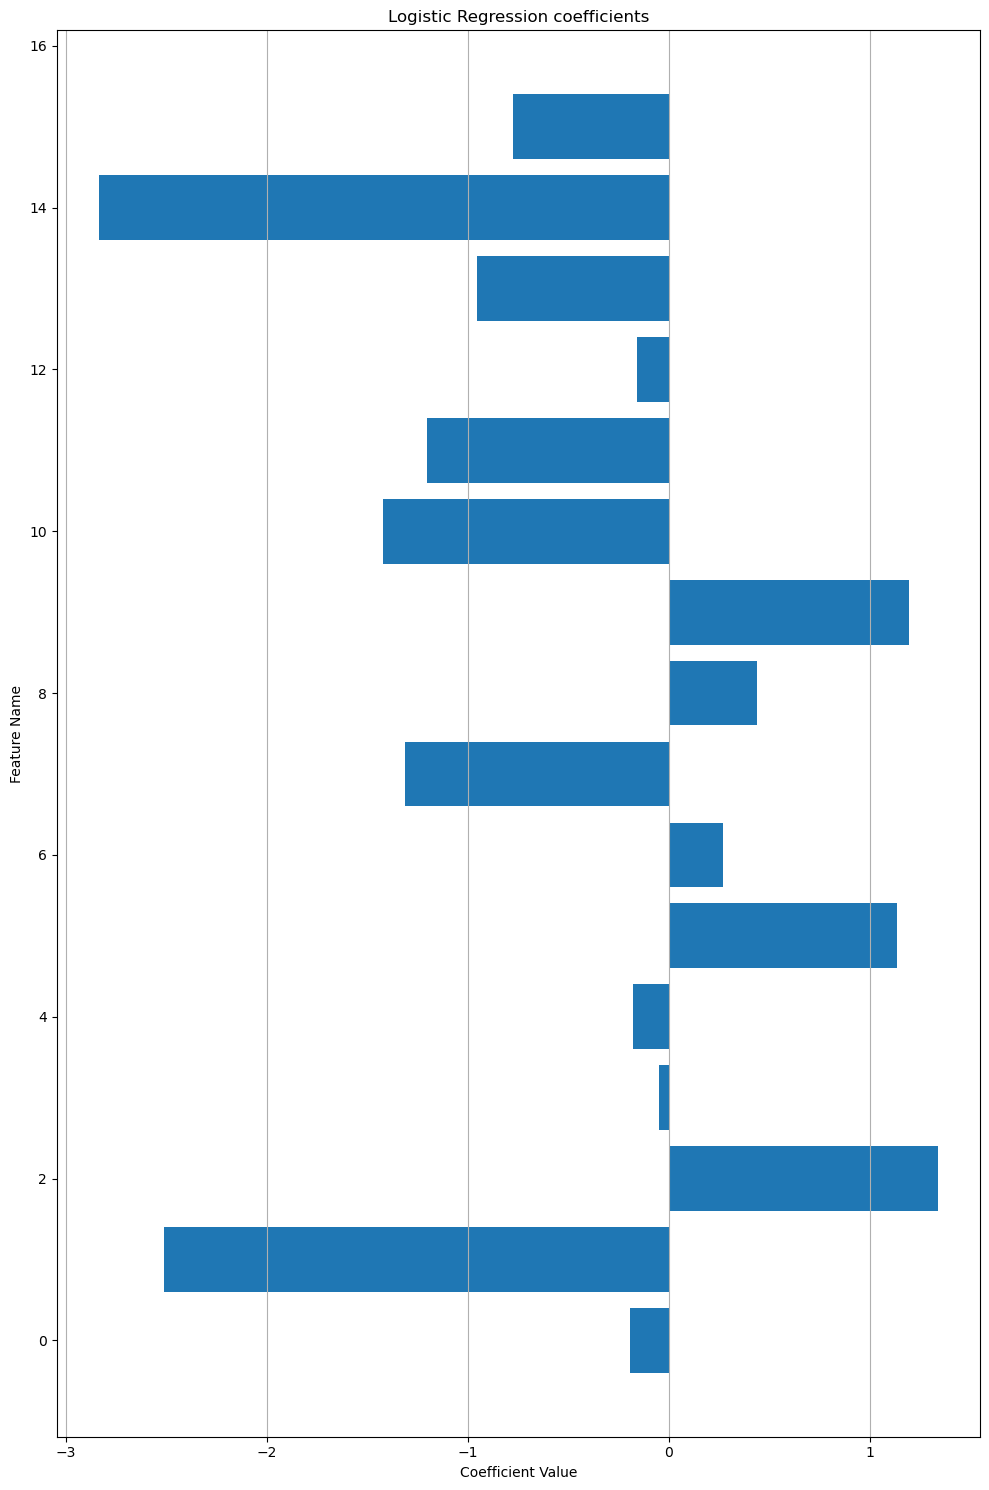

In [164]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Build and train the model
logistic_model = LogisticRegression(max_iter=10000, n_jobs=-1)  # Default is L2 regularization
logistic_model.fit(X_train, y_train.values.ravel())

# Predict and evaluate
train_pred = logistic_model.predict(X_train)
test_pred = logistic_model.predict(X_test)

# Evaluate model
evaluate_classifier(y_train, train_pred, y_test, test_pred, "Logistic Regression")

# Extract coefficients
coefficients = logistic_model.coef_[0]
features = X_train.columns

# Sort coefficients and features for better visualization
sorted_idx = np.argsort(coefficients)
features = np.array(features)[sorted_idx]
coefficients = coefficients[sorted_idx]

# Plot coefficients
plt.figure(figsize=(10, 15))
plt.barh(features, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Logistic Regression coefficients')
plt.grid(axis='x')
plt.tight_layout()
plt.savefig(f'output/logisticRegression.png')
plt.show()

### Random Forests

Evaluation Metrics for Random Forest (n_estimators=50):

Confusion Matrix:
Training:
 [[17565     0     0     0     1]
 [    2  3216     3     0     0]
 [    0     0  8522     0     1]
 [    0     0     5  1578     0]
 [    0     0     2     0  2829]]
Test:
 [[7445  116   10    2    6]
 [ 112  399  168    0   96]
 [  24  240 3342   69  166]
 [   0    0  192  203    0]
 [ 125  166   97    0  923]]

Zero-One Loss:
Training: 0.000
Test: 0.114

Accuracy
Training: 1.000
Test: 0.886

Precision:
Training: 1.000
Test: 0.759

Recall:
Training: 0.999
Test: 0.717

F1 Score:
Training: 0.999
Test: 0.733


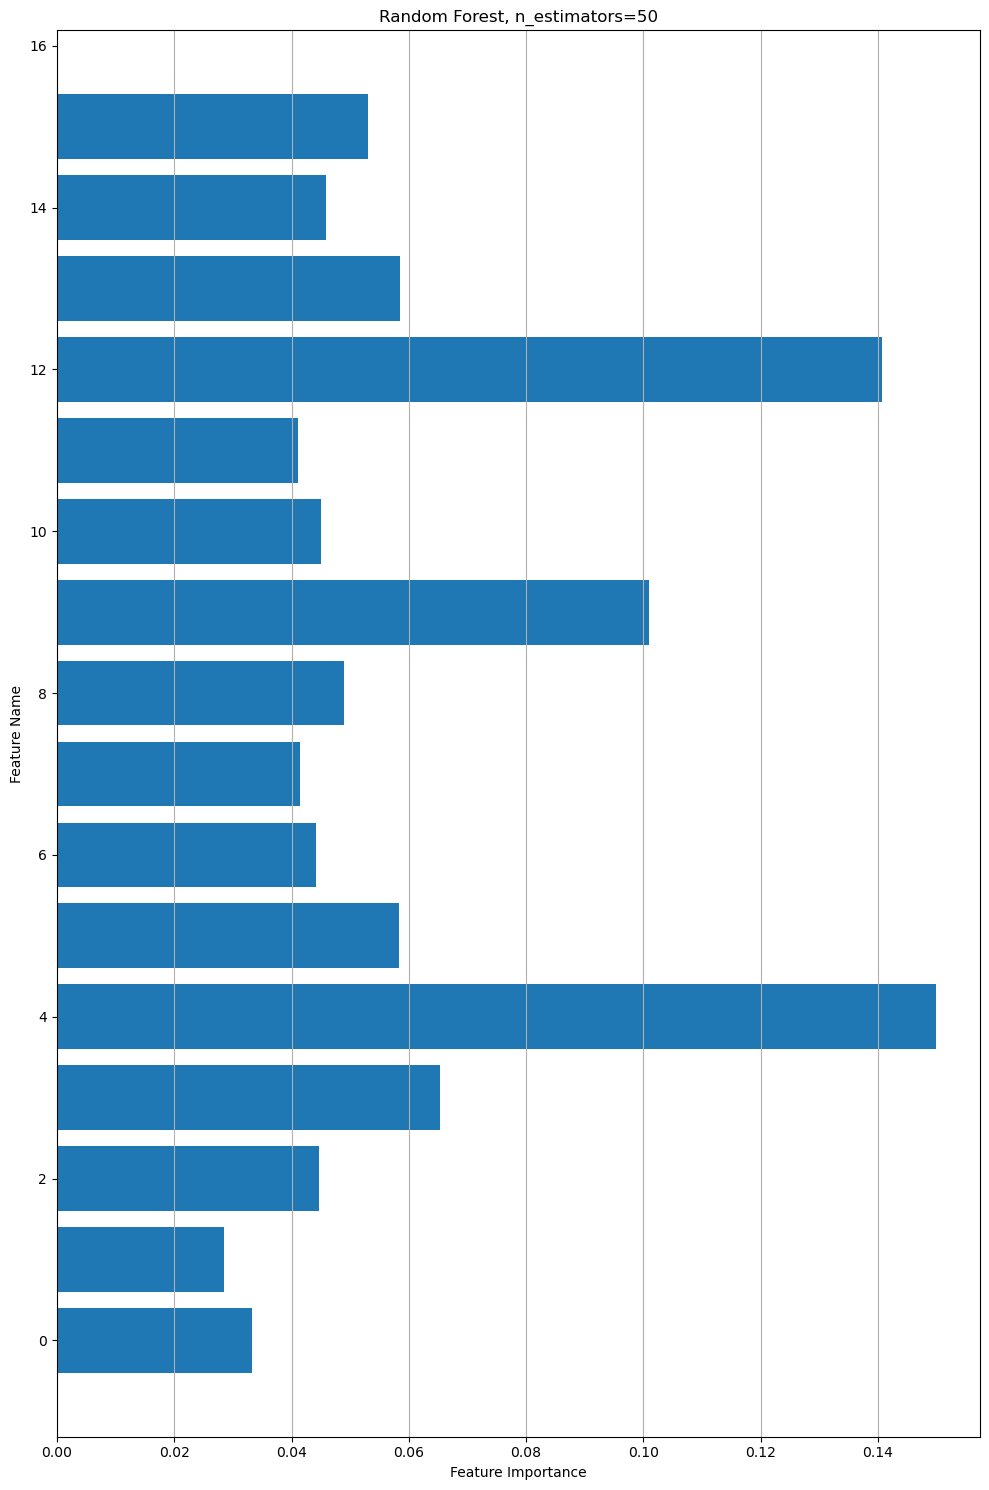

Evaluation Metrics for Random Forest (n_estimators=100):

Confusion Matrix:
Training:
 [[17566     0     0     0     0]
 [    0  3221     0     0     0]
 [    0     0  8523     0     0]
 [    0     0     0  1583     0]
 [    0     0     0     0  2831]]
Test:
 [[7442  118   12    2    5]
 [ 105  408  163    0   99]
 [  24  230 3353   70  164]
 [   0    0  176  219    0]
 [ 122  173   92    0  924]]

Zero-One Loss:
Training: 0.000
Test: 0.112

Accuracy
Training: 1.000
Test: 0.888

Precision:
Training: 1.000
Test: 0.764

Recall:
Training: 1.000
Test: 0.728

F1 Score:
Training: 1.000
Test: 0.742


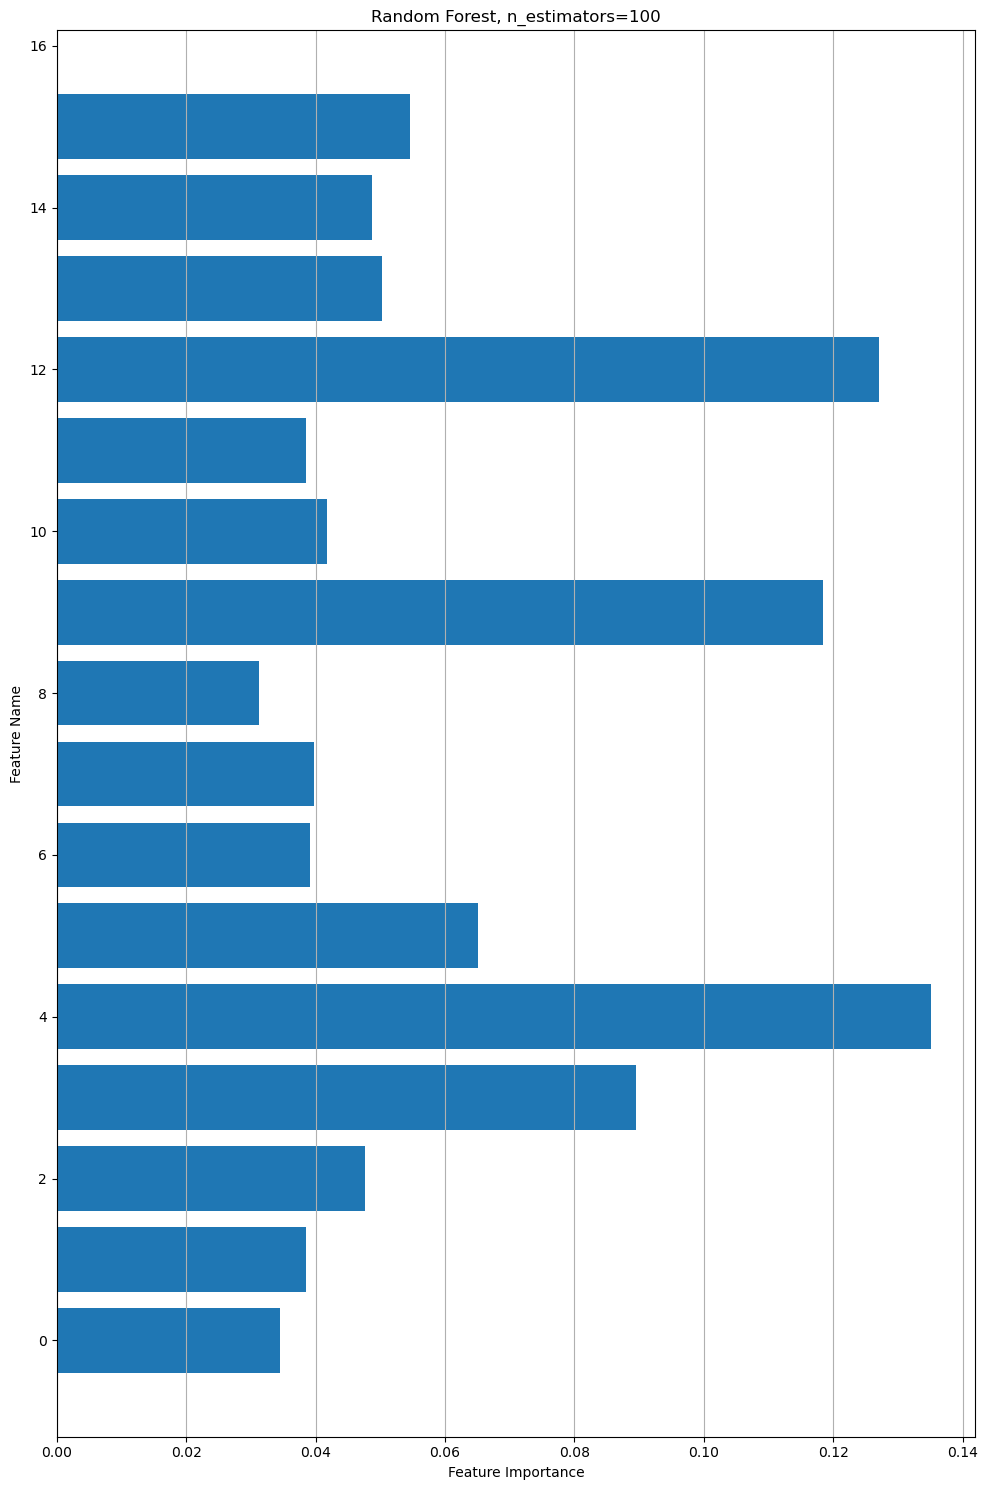

Evaluation Metrics for Random Forest (n_estimators=200):

Confusion Matrix:
Training:
 [[17566     0     0     0     0]
 [    0  3221     0     0     0]
 [    0     0  8523     0     0]
 [    0     0     0  1583     0]
 [    0     0     0     0  2831]]
Test:
 [[7447  112   11    2    7]
 [ 105  396  175    0   99]
 [  22  222 3359   74  164]
 [   0    0  177  218    0]
 [ 114  163   95    0  939]]

Zero-One Loss:
Training: 0.000
Test: 0.111

Accuracy
Training: 1.000
Test: 0.889

Precision:
Training: 1.000
Test: 0.762

Recall:
Training: 1.000
Test: 0.727

F1 Score:
Training: 1.000
Test: 0.741


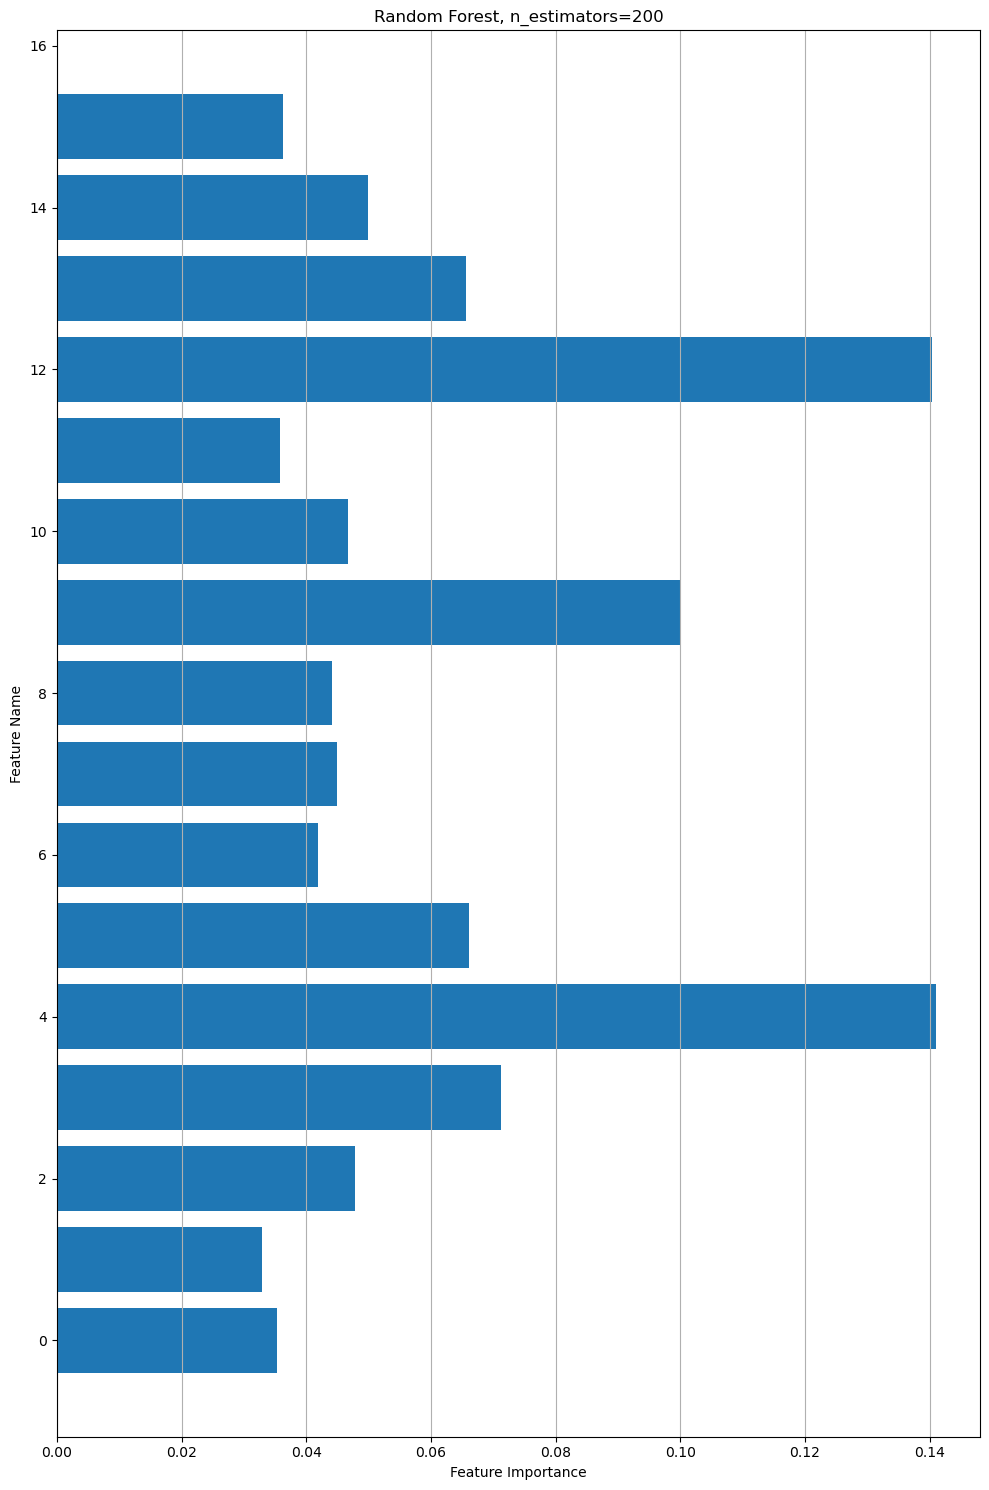

In [161]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, features, n_trees):
    """Plots the feature importances of a random forest classifier"""
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(10, 15))
    plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title(f'Random Forest, n_estimators={n_trees}')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.savefig(f'output/randomForest_n_estimators={n_trees}.png')
    plt.show()

for n_trees in [50, 100, 200]:
    # Build and train the model
    rf_model = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1)
    rf_model.fit(X_train, y_train.values.ravel())
    
    # Predict and evaluate
    train_pred = rf_model.predict(X_train)
    test_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    evaluate_classifier(y_train, train_pred, y_test, test_pred, f"Random Forest (n_estimators={n_trees})")
    
    # Plot feature importances
    plot_feature_importances(rf_model, X_train.columns, n_trees)

### k-Nearest-Neighbor Classification

In [165]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
# Rule of thumb: sqrt(n) where n is the number of samples: https://quantdev.ssri.psu.edu/sites/qdev/files/kNN_tutorial.html
# 4 set in the training dataset and 1 set for validation. Total containing 33724 samples, so sqrt(33724/4) = 92
param_grid = {'n_neighbors': list(range(1, 300))}  # Considering 1 to 150 neighbors

# Use GridSearchCV to find the best number of neighbors
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, return_train_score=True, n_jobs=-1, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train.values.ravel())

# Train the model with the best number of neighbors
best_knn = grid_search.best_estimator_
train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate the model
evaluate_classifier(y_train, train_pred, y_test, test_pred, "K-Nearest Neighbors")

# Plot the cross-validation results
k_values = grid_search.cv_results_['param_n_neighbors'].data
plt.figure(figsize=(12, 6))
plt.plot(k_values, grid_search.cv_results_['mean_train_score']*100, label="Train error")
plt.plot(k_values, grid_search.cv_results_['mean_test_score']*100, label='Test error')
plt.title('Mean Train and Test Scores vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Score (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('output/knn.png')
plt.show()

# 2. Invariance and normalization (30 points)

Mean of x: 34.5
Mean of y: 37.5

Centered coordinates for Mr. Good: [12.5 -2.5]
Centered coordinates for Mr. Bad: [-12.5   2.5]
Centered coordinates for Mr. Unknown: [-13.5  -1.5]

Variance of x: 156.25
Variance of y: 6.25

Standard deviation of x: 12.5
Standard deviation of y: 2.5

Normalized coordinates for Mr. Good: [1.0, -1.0]
Normalized coordinates for Mr. Bad: [-1.0, 1.0]
Normalized coordinates for Mr. Unknown: [-1.08, -0.6]


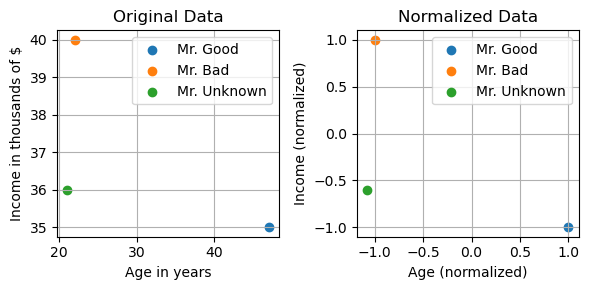

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Original data
data = {
    "Mr. Good":     np.array([47, 35]),
    "Mr. Bad":      np.array([22, 40]),
    "Mr. Unknown":  np.array([21, 36])
}

# Calculate means
mean_x = np.mean([data["Mr. Good"][0], data["Mr. Bad"][0]])
mean_y = np.mean([data["Mr. Good"][1], data["Mr. Bad"][1]])

print(f"Mean of x: {mean_x}")
print(f"Mean of y: {mean_y}\n")

# Center the data (zero mean)
centered_data = {key: value - [mean_x, mean_y] for key, value in data.items()}

for key, value in centered_data.items():
    print(f"Centered coordinates for {key}: {value}")

# Calculate variances
var_x = np.var([centered_data["Mr. Good"][0], centered_data["Mr. Bad"][0]])
var_y = np.var([centered_data["Mr. Good"][1], centered_data["Mr. Bad"][1]])

print(f"\nVariance of x: {var_x}")
print(f"Variance of y: {var_y}")

# Calculate standard deviations
std_x = np.sqrt(var_x)
std_y = np.sqrt(var_y)

print(f"\nStandard deviation of x: {std_x}")
print(f"Standard deviation of y: {std_y}\n")

# Normalize the data (variance one)
normalized_data = {key: [value[0]/std_x, value[1]/std_y] for key, value in centered_data.items()}

for key, value in normalized_data.items():
    print(f"Normalized coordinates for {key}: {value}")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Original data plot
for key, value in data.items():
    ax[0].scatter(value[0], value[1], label=key)
ax[0].set_title("Original Data")
ax[0].set_xlabel("Age in years")
ax[0].set_ylabel("Income in thousands of $")
ax[0].grid(True)
ax[0].legend()

# Normalized data plot
for key, value in normalized_data.items():
    ax[1].scatter(value[0], value[1], label=key)
ax[1].set_title("Normalized Data")
ax[1].set_xlabel("Age (normalized)")
ax[1].set_ylabel("Income (normalized)")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.savefig('output/invariance_and_normalization.png')
plt.show()

# 3. Differentiable programming (35 points)

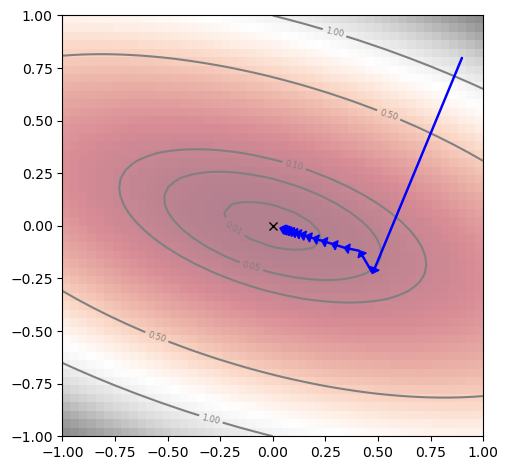

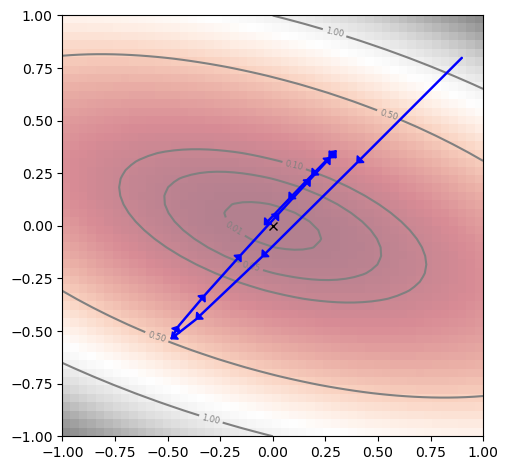

In [137]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Parameter affecting the shape of the quadratic function
p_f = 0.5  

# Quadratic function definition
def f(x, y):
    """Compute the value of the function for given x and y."""
    return (p_f*x)**2 + y**2 + p_f*x*y

def gradient_descent_plot(optimizer_type, p_x, p_y, r, n_iter):
    """
    Plot the contour of the function and the gradient descent path.
    
    Parameters:
    - p_x, p_y: Lists containing x and y coordinates of the gradient descent path.
    - r: Range for plotting.
    - n_iter: Number of iterations.
    """
    # Generate meshgrid for contour plot
    x = np.linspace(-r, r, 50)
    y = np.linspace(-r, r, 50)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # Draw contour lines and fill
    contours = plt.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.5, 1.], colors='grey')
    plt.clabel(contours, inline=True, fontsize=6)
    plt.imshow(Z, extent=[-r, r, -r, r], origin='lower', cmap='RdGy', alpha=0.5)

    # Mark the optimum point
    plt.plot(0, 0, 'x', c='k')

    # Plot arrows showing the gradient descent path
    for i in range(n_iter):
        plt.arrow(p_x[i], p_y[i], p_x[i+1]-p_x[i], p_y[i+1]-p_y[i], width=.005, head_width=.045, head_length=.025, length_includes_head=True, fc='b', ec='b', zorder=10)
    
    # Save plot
    plt.tight_layout()
    plt.savefig(f'output/gradient_descent_{optimizer_type}.png')
    plt.show()

def perform_gradient_descent(optimizer_type, eta, n_iter, r):
    """
    Perform gradient descent optimization and store the path.
    
    Parameters:
    - optimizer_type: Type of optimizer to use ("SGD" or "Adam").
    - eta: Learning rate.
    - n_iter: Number of iterations.
    - r: Range for initial point.
    """
    # Initialize starting point
    x = torch.ones(1, requires_grad=True)
    y = torch.ones(1, requires_grad=True)
    with torch.no_grad():
        x *= 0.9*r
        y *= 0.8*r

    # Lists to store path of gradient descent
    p_x = [x.item()]
    p_y = [y.item()]

    # Choose optimizer based on input
    if optimizer_type == "SGD":
        optimizer = torch.optim.SGD([x, y], lr=eta)
    elif optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x, y], lr=eta)
    else:
        raise ValueError("Unsupported optimizer type")

    # Gradient descent loop
    for i in range(n_iter):
        optimizer.zero_grad()
        f(x, y).backward()
        optimizer.step()
        p_x.append(x.item())
        p_y.append(y.item())

    # Plot the results of gradient descent
    gradient_descent_plot(optimizer_type, p_x, p_y, r, n_iter)

# Range for plotting the function
r = 1.

# Perform and plot gradient descent using SGD optimizer
perform_gradient_descent("SGD", eta = 0.5, n_iter = 15, r = r)

# Perform and plot gradient descent using Adam optimizer
perform_gradient_descent("Adam", eta = 0.5, n_iter = 15, r = r)

### Why does the fourth step go in the “wrong” direction?
Adam is an adaptive learning rate optimization algorithm that combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. One of the key features of Adam is that it uses moving averages of the parameters (momentum) which can sometimes lead to overshooting the optimal point, especially in the early stages of optimization when the moving averages are being established.

In the early iterations, the momentum term can dominate the optimization, causing the update to move in the direction of the momentum rather than the direction of the gradient. This can lead to the optimizer taking steps that appear to be in the "wrong" direction with respect to the gradient. However, as more iterations are performed, the moving averages stabilize, and the optimizer becomes more responsive to the gradient, leading to more consistent convergence towards the minimum.

In summary, the "wrong" direction in the fourth step (or any early step) can be attributed to the momentum term in the Adam optimizer, which can initially dominate the gradient-based updates.